In [12]:
# Text text processing library
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import itertools as it
from models import *
from helpers import *
# import main
import matplotlib.pyplot as plt
import spacy
import time
MAX_LEN = 20
MIN_FREQ = 5

In [13]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
DE = data.Field(tokenize=tokenize_de)

# only target needs BOS/EOS:
EN = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, eos_token = EOS_WORD) 

train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(DE, EN), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)

In [14]:
DE.build_vocab(train.src, min_freq=MIN_FREQ)
EN.build_vocab(train.trg, min_freq=MIN_FREQ)

pred_set = []
for i, line in enumerate(open("source_test.txt"), 1):
    words = line.split()[:-1]
    pred_set.append([DE.vocab.stoi[s] for s in words])

train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))

In [15]:
batch = next(iter(test_iter))
# sent_inspect(batch,4)
def sent_inspect(batch, idx=0):
    print("Source")
    print(' '.join([DE.vocab.itos[w] for w in batch.src.data[:,idx]]))
    print("Target")
    print(' '.join([EN.vocab.itos[w] for w in batch.trg.data[:,idx]]))
# print(DE.vocab.stoi['<pad>'])

In [ ]:
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))
bs_encoder = BaseEncoder(DE, hidden_size=500, num_layers=4, word_features=500)
bs_decoder = BaseDecoder(EN, hidden_size=500, num_layers=4, word_features=500)
trainer = NMTTrainer([bs_encoder, bs_decoder], DE, EN, lrn_rate=0.7, 
                     lrn_decay='adaptive', reverse_enc_input=False)
evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, reverse_enc_input=False)
trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter)

Target padding token: 1
Using CUDA...
Target padding token: 1
Using CUDA...
Epoch 0, loss: 68.804482, norm: 4.713892, elapsed: 480.698272, lrn_rate: 0.700000
Validation time: 0.752825 seconds
Validation set metric: 14.507076
Epoch 1, loss: 64.434280, norm: 5.689084, elapsed: 963.759561, lrn_rate: 0.700000
Validation time: 0.738729 seconds
Validation set metric: 10.272312
Epoch 2, loss: 56.084084, norm: 6.996671, elapsed: 1447.112933, lrn_rate: 0.700000
Validation time: 0.718113 seconds
Validation set metric: 8.533530
Epoch 3, loss: 39.182854, norm: 5.212823, elapsed: 1931.421803, lrn_rate: 0.700000
Validation time: 0.716954 seconds
Validation set metric: 7.516261
Epoch 4, loss: 46.313068, norm: 7.776521, elapsed: 2415.209798, lrn_rate: 0.700000
Validation time: 0.717423 seconds
Validation set metric: 7.031395
Epoch 5, loss: 40.980598, norm: 6.899519, elapsed: 2899.272682, lrn_rate: 0.700000
Validation time: 0.720704 seconds
Validation set metric: 6.896355
Epoch 6, loss: 42.708160, norm

In [ ]:
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))
bs_encoder = BaseEncoder(DE, hidden_size=500, num_layers=4, word_features=500, dropout=0.2)
# TODO: decide whether to add dropout to output states of encoder!
bs_decoder = AttnDecoder(EN, hidden_size=500, num_layers=4, word_features=500, dropout=0.2)
trainer = NMTTrainer([bs_encoder, bs_decoder], DE, EN, lrn_rate=1.0, 
                     lrn_decay='adaptive', attention=True)
evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, attention=True,
                        record_attention=True, visualize_freq=50)
trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter)

Target padding token: 1
Using CUDA...
Target padding token: 1
Using CUDA...


In [10]:
for i in range(10):
    print(' '.join(DE.vocab.itos[w] for w in debug_set[i]))
    print(' '.join(EN.vocab.itos[w] for w in debug_ans[i]))    

NameError: name 'debug_set' is not defined

In [74]:
print(evaluator.evaluate(val_iter))
print(len(train_iter))
sample = evaluator.attns_log[0]
attn = sample[0][7].cpu().data.numpy()
src_words = np.array(list(map(lambda x: DE.vocab.itos[x], sample[1][7].cpu().data.numpy())))
pred_words = np.array(list(map(lambda x: EN.vocab.itos[x], sample[2][7].cpu().data.numpy())))
print(attn, src_words, pred_words)
val_iter.init_epoch()
batch = next(iter(val_iter))
sent_inspect(batch, 4)

Validation time: 0.227288 seconds
44.62296943611147
3722
[[0.3444936  0.21377848 0.22162947 0.22009845]
 [0.26543933 0.24090041 0.24601129 0.24764895]
 [0.26933482 0.24343687 0.24473654 0.24249181]
 [0.23431073 0.25176635 0.2556089  0.25831398]
 [0.24062863 0.25227922 0.25303474 0.25405735]
 [0.23847908 0.25292277 0.25366053 0.2549376 ]
 [0.23905838 0.2531099  0.25337002 0.2544617 ]
 [0.23879042 0.2531038  0.25345555 0.25465024]] ['Ich' 'war' 'verzweifelt' '.'] ['And' "'s" '.' '.' '</s>' '</s>' '</s>' '</s>']
Source
Ich hatte Angst –
Target
<s> And I was scared . </s> <pad> <pad>


/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


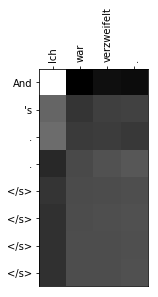

In [76]:
fig, ax = plt.subplots()

ax.imshow(attn, cmap='gray')
plt.xticks(range(len(src_words)),src_words, rotation='vertical')
plt.yticks(range(len(pred_words)),pred_words)
ax.xaxis.tick_top()
plt.show()

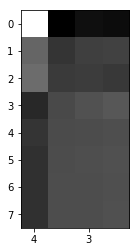

In [63]:
fig, ax = plt.subplots(1,1)
ax.imshow(attn, cmap='gray')
ax.set_xticklabels(['i', '4', '3', '1'])
plt.show()

In [127]:
print(EN.vocab.stoi['<s>'])
print(EN.vocab.itos[2])

2
<s>


## OLD STUFF BELOW HERE

In [23]:
# evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, reverse_enc_input=False)
evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, attention=True,
                        record_attention=True)
print(evaluator.evaluate(test_iter))
print(evaluator.evaluate(val_iter))
test_iter.init_epoch()
debug_iter = iter(test_iter)
for i in range(10):
    batch = next(debug_iter)
debug_set = [batch.src.data[:, i] for i in range(batch.src.data.size(1))]
debug_ans = [batch.trg.data[:, i] for i in range(batch.trg.data.size(1))]
evaluator.predict(pred_set, fn='predictions.txt',beam_size=100)

Target padding token: 1
Using CUDA...


RuntimeError: cat(): argument 'tensors' (position 1) must be tuple of Variables, not Variable